# A posteriori prediction

Errors made at any step gets accumulated.

In [1]:
# add parent folder to search directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, optimizers
from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, Dropout

from MR import MaxeyRiley
from flow_interpolater import flow_interpolater
from matplotlib import animation, rc
from matplotlib.patches import Circle
from IPython.display import HTML
from predictors import rnn_predict, fullmr_predict, slowmanifold_predict

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
plt.rc('text', usetex=True)

### Model structure is defined below.

In [4]:
class rnn_predictor(object):
    
    def __init__(self, input_dims, output_dims, lstm_units=128, dense_units=64,
                input_mean=0, input_std=1):
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.build_spinup(lstm_units, dense_units)
        self.build_step(lstm_units, dense_units)
        self.input_mean = input_mean
        self.input_std = input_std
        
    def build_spinup(self, lstm_units, dense_units):
        xi = layers.Input(shape=(None, self.input_dims))
        lstm_layer = layers.recurrent.LSTM(lstm_units, input_shape=(None, self.input_dims), return_state=True)
        out, *states = lstm_layer(xi)
        out = layers.Dropout(.2)(out)
#         out = layers.Dense(dense_units, activation='relu')(out)
        out = layers.Dense(dense_units)(out)
        out = layers.Dropout(.2)(out)
        out = layers.Dense(2, activation='linear')(out)
        self.models = Model(inputs=[xi], outputs=[out] + states)
        self.models.compile(optimizer='adam', loss='mse')
        
    def build_step(self, lstm_units, dense_units):
        xi = layers.Input(shape=(None, self.input_dims))
        states0 = [layers.Input(shape=(lstm_units,)), layers.Input(shape=(lstm_units,))]
        
        lstm_layer = layers.recurrent.LSTM(lstm_units, input_shape=(1, self.input_dims), return_state=True)
        out, *states = lstm_layer(xi, initial_state=states0)
        out = layers.Dropout(.2)(out)
#         out = layers.Dense(dense_units, activation='relu')(out)
        out = layers.Dense(dense_units)(out)
        out = layers.Dropout(.2)(out)
        out = layers.Dense(2, activation='linear')(out)
        self.model1 = Model(inputs=[xi]+states0, outputs=[out]+states)
        self.model1.compile(optimizer='adam', loss='mse')
    
    def load_weights(self, weights):
        self.models.load_weights(weights)
        self.model1.load_weights(weights)
    
    def spinup(self, inputs):
        return self.models.predict([inputs])
    
    def step(self, inputs):
        return self.model1.predict(inputs)
    

### Load training file for the input shift and scale.

In [5]:
file = np.load('particle_results_organized/test2/cf_training.npz')
U, DUDt = file['U'], file['DUDt']
features = np.concatenate((U, DUDt), axis=-1)    # concatenate with velocity vector
feat_mean, feat_std = np.mean(features, axis=(0,1)), np.std(features, axis=(0,1))

In [6]:
# define the flow and mr object
ep, R = .05, 1.55
fi = flow_interpolater('interpolaters/Re250_force1_k4_interp4999.npz')
# fi = flow_interpolater('interpolaters/Re250_force06_k15_interp4000.npz')
mr = MaxeyRiley(ep, R, flow=fi)

### Get trajectories using full-dimension true model equations.

[[ 0.63217342 -0.17503092]
 [-0.02616758  0.2174905 ]
 [-0.02718145  0.21737942]
 ...
 [ 0.63222666 -0.17558348]
 [ 0.63225754 -0.17494519]
 [ 0.63222664 -0.17558266]]


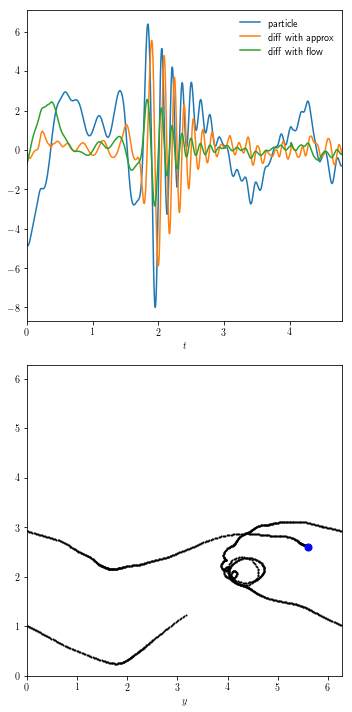

In [148]:
dt = 4e-3
steps = 1200

# initial condition
# np.random.seed(1111)

t0 = 0
pts = 2000
x0 = np.random.rand(pts, 2)*2*np.pi
v0 = mr.order1_manifold_vel(x0, t=t0)

## full mr - ground truth
x, v, u, DuDt, vm = fullmr_predict(x0, v0, steps, mr, dt, t0)
x = np.mod(x, 2*np.pi)
vd_t = v - u

## result verification
print(v[-1,:]-vm[-1,:])
fig, ax = plt.subplots(2, 1, figsize=(5,10))

plot_steps = steps
case = 0
ax[0].plot(np.arange(plot_steps)*dt, v[:plot_steps,case,1], label='particle')
ax[0].plot(np.arange(plot_steps)*dt, v[:plot_steps,case,1]-vm[:plot_steps,case,1], label='diff with approx')
ax[0].plot(np.arange(plot_steps)*dt, v[:plot_steps,case,1]-u[:plot_steps,case,1], label='diff with flow')
ax[0].set_xlim([0, plot_steps*dt])
ax[0].set_xlabel('$t$')
ax[0].legend(frameon=False)

ax[1].scatter(x[:plot_steps,case,0], x[:plot_steps,case,1], 1, 'k')
ax[1].scatter(x[plot_steps-1,case,0], x[plot_steps-1,case,1], 50, 'b')
ax[1].set_xlim([0, 2*np.pi])
ax[1].set_xlabel('$x$')
ax[1].set_ylim([0, 2*np.pi])
ax[1].set_xlabel('$y$')

plt.tight_layout()
plt.show()


### Get trajectories using RNN model (errors do accumulate)

In [149]:
steps0 = 200
steps = 1000
steps1 = steps + steps0

rp = rnn_predictor(input_dims=4, output_dims=2, input_mean=feat_mean, input_std=feat_std)
weights = 'particle_results_organized/test2/weights/weights_800epochs_linear.h5'
# weights = 'weights_v-u_800epochs_relu.h5'
rp.load_weights(weights)

x_p, v_p, u_p, DuDt_p, vm_p, vt_p = rnn_predict(x0, v0, rp, steps0, steps, mr, dt, t0, option=0)
x_p = np.mod(x_p, 2*np.pi)
vd_p = v_p - u_p


In [44]:
print(x_p.shape)

(500, 1000, 2)


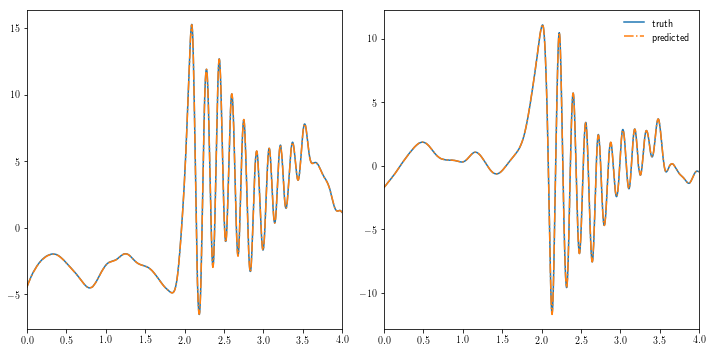

-0.0031186869893794537


In [150]:
case = 162

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(np.arange(steps)*dt, vt_p[:, case, 0], '-', label='truth')
ax[0].plot(np.arange(steps)*dt, v_p[:, case, 0], '-.', label='predicted')
# ax[0].plot(np.arange(steps)*dt, vm_p[:, 0], '-.', label='1st order')
# ax[0].plot(np.arange(steps)*dt, vt_p[:, 0] - v_p[:, 0], 'b:')
# ax[0].plot(np.arange(steps)*dt, vt_p[:, 0] - vm_p[:, 0], 'g:')
ax[0].set_xlim([0, dt*steps])

ax[1].plot(np.arange(steps)*dt, vt_p[:, case, 1], '-', label='truth')
ax[1].plot(np.arange(steps)*dt, v_p[:, case, 1], '-.', label='predicted')
# ax[1].plot(np.arange(steps)*dt, v_p[:, 1] - vt_p[:, 1], ':', label='diff')
ax[1].set_xlim([0, dt*steps])
ax[1].legend(frameon=False)

plt.tight_layout()
plt.show()

print(np.mean(v_p - vt_p))

In [151]:
x_m, u_m, DuDt_m, vm_m = slowmanifold_predict(x[steps0,:], steps, mr, dt, t0+dt*steps0)
x_m = np.mod(x_m, 2*np.pi)
vd_m = vm_m - u_m

### plot error statistics

In [152]:
rmse_p = np.mean(np.sum((v_p - vt_p)**2, axis=-1), axis=1)**.5
rmse_m = np.mean(np.sum((v_p - vm_p)**2, axis=-1), axis=1)**.5

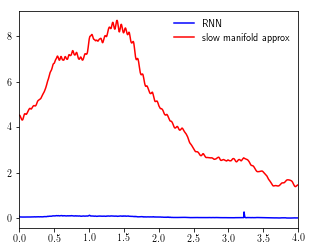

In [153]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(np.arange(steps)*dt, rmse_p, 'b-', label='RNN')
ax.plot(np.arange(steps)*dt, rmse_m, 'r-', label='slow manifold approx')
ax.legend(frameon=False)
ax.set_xlim([0, dt*steps])

# plt.tight_layout()
plt.savefig('xx.png', dpi=200)
plt.show()

### save to .mat file for plotting

In [15]:
import scipy.io as sio

In [ ]:
savedict = {'xt':x, 'vt':v, 'ut':u, 'xp':x_p, 'vp':v_p, 'up':u_p}
sio.savemat('multistep_pred_5000pts.mat', savedict)
# np.savez('vKpred.npz', xt=x, vt=v, xm=x_m, vm=vm_m, xp=x_p, vp=v_p)

In [92]:
# for plotting pdf of velocity difference between particle and flow
savedict = {'vd_t':vd_t, 'vd_p':vd_p, 'vd_m':vd_m}
sio.savemat('vd1000_t70.mat', savedict)

In [154]:
# for plotting autocorrelation and spectrum
savedict = {'vt':v, 'vp':v_p, 'vm':vm_m}
sio.savemat('v2000_t00.mat', savedict)

### plot density for v-u

In [14]:
from scipy.stats import gaussian_kde

def pdf(data, pts=500):
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), pts)
    p = kde(x)
    return x,p

In [15]:
v_u_t = v - u
v_u_p = v_p - u_p
v_u_m = vm_m - u_m

In [16]:

vdx_t, pvdx_t = pdf(v_u_t[::2,:,0].flatten())
vdy_t, pvdy_t = pdf(v_u_t[::2,:,1].flatten())

vdx_p, pvdx_p = pdf(v_u_p[::2,:,0].flatten())
vdy_p, pvdy_p = pdf(v_u_p[::2,:,1].flatten())


KeyboardInterrupt: 

In [63]:
vdx_m, pvdx_m = pdf(v_u_m[::2,:,0].flatten())
vdy_m, pvdy_m = pdf(v_u_m[::2,:,1].flatten())

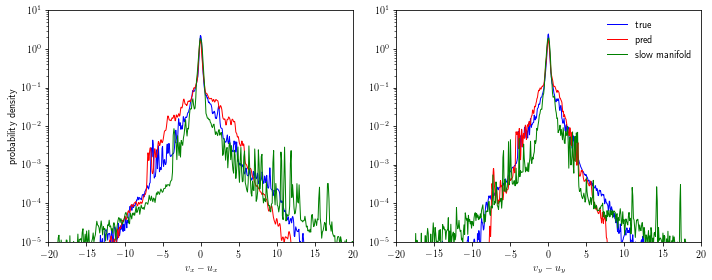

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].semilogy(vdx_t, pvdx_t, 'b-', linewidth=1, label='true')
ax[0].semilogy(vdx_p, pvdx_p, 'r-', linewidth=1, label='pred')
ax[0].semilogy(vdx_m, pvdx_m, 'g-', linewidth=1, label='slow manifold')
ax[0].set_xlim([-20, 20])
ax[0].set_ylim([1e-5, 1e1])
ax[0].set_xlabel('$v_x - u_x$')
ax[0].set_ylabel('probability density')

ax[1].semilogy(vdy_t, pvdy_t, 'b-', linewidth=1, label='true')
ax[1].semilogy(vdy_p, pvdy_p, 'r-', linewidth=1, label='pred')
ax[1].semilogy(vdy_m, pvdy_m, 'g-', linewidth=1, label='slow manifold')
ax[1].set_xlim([-20, 20])
ax[1].set_ylim([1e-5, 1e1])
ax[1].set_xlabel('$v_y - u_y$')
ax[1].legend(frameon=False)

# plt.savefig('pdf_v-u.png', dpi=200);
plt.tight_layout()
plt.show()

In [25]:
vd_t, pvd_t = pdf(v_u_t[::1,:,:].flatten())

In [26]:
vd_p, pvd_p = pdf(v_u_p[::1,:,:].flatten())

In [27]:
vd_m, pvd_m = pdf(v_u_m[::1,:,:].flatten())

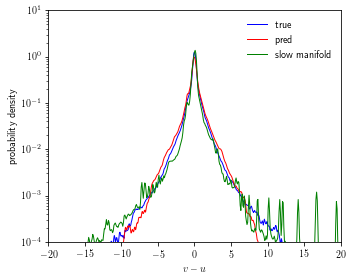

In [28]:
fig, ax = plt.subplots(figsize=(5,4))
ax.semilogy(vd_t, pvd_t, 'b-', linewidth=1, label='true')
ax.semilogy(vd_p, pvd_p, 'r-', linewidth=1, label='pred')
ax.semilogy(vd_m, pvd_m, 'g-', linewidth=1, label='slow manifold')
ax.set_xlim([-20, 20])
ax.set_ylim([1e-4, 1e1])
ax.set_xlabel('$v - u$')
ax.set_ylabel('probability density')
ax.legend(frameon=False)

# plt.savefig('pdf_v-u_xycombined.png', dpi=200);
plt.tight_layout()
plt.show()

### plot and compare mult-step predictions

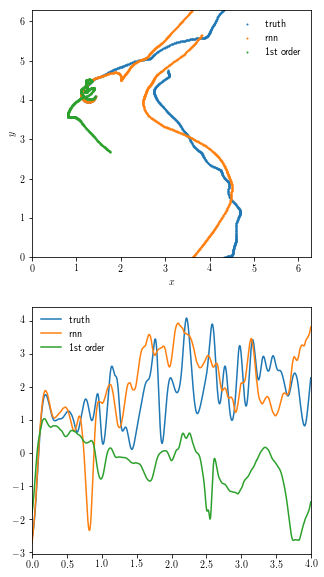

In [51]:
case = 105
fig2, ax2 = plt.subplots(2, 1, figsize=(5,10))
ax2[0].scatter(x[steps0:steps1, case, 0], x[steps0:steps1, case, 1], 1, label='truth')
ax2[0].scatter(x_p[:,case,0], x_p[:,case,1], 1, label='rnn')
ax2[0].scatter(x_m[:,case,0], x_m[:,case,1], 1, label='1st order')
ax2[0].set_xlim([0, 2*np.pi])
ax2[0].set_ylim([0, 2*np.pi])
ax2[0].set_xlabel('$x$')
ax2[0].set_ylabel('$y$')
ax2[0].legend(frameon=False)

ax2[1].plot(np.arange(steps)*dt, v[steps0:steps1, case, 1], label='truth')
ax2[1].plot(np.arange(steps)*dt, v_p[:, case, 1], label='rnn')
ax2[1].plot(np.arange(steps)*dt, vm_m[:, case, 1], label='1st order')
ax2[1].set_xlim([0, dt*steps])
# ax2[1].set_xlim([0, 2.5])
ax2[1].legend(frameon=False)

plt.show()

In [5]:
a = np.zeros((3,3,3))
print(a.shape[2])

3
